In [2]:
import nibabel as nib
import torch
import os
from tqdm.notebook import trange,tqdm
import torch.nn.functional as F
import torch.nn as nn
import sys
import time
import numpy as np
import matplotlib.pyplot as plt

#os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
#os.environ['CUDA_VISIBLE_DEVICES'] = '0'
print(torch.cuda.get_device_name())

#torch.cuda.set_per_process_memory_fraction(0.25, 0)


Tesla V100-SXM3-32GB


In [3]:
train_source_data = torch.load('HackathonDA_CHAOS_T1_source.pth')['train_source_data']
pseudo_source_data = torch.load('HackathonDA_CHAOS_T1_source.pth')['pseudo_source_data']
for pseudo in pseudo_source_data: 
    train_source_data.append(pseudo)
len(train_source_data)

40

In [24]:
print(train_source_data[0].shape)

torch.Size([3, 35, 192, 285])


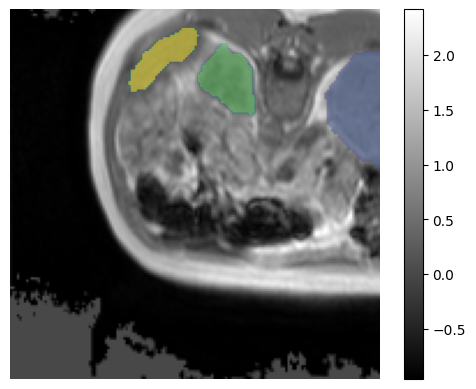

In [26]:
def dice_coeff(outputs, labels, max_label):
    dice = torch.FloatTensor(max_label-1).fill_(0)
    for label_num in range(1, max_label):
        iflat = (outputs==label_num).view(-1).float()
        tflat = (labels==label_num).view(-1).float()
        intersection = torch.mean(iflat * tflat)
        dice[label_num-1] = (2. * intersection) / (1e-8 + torch.mean(iflat) + torch.mean(tflat))
    return dice

def load_batch_train(train_data,batch_idx,affine_rand=0.05):
    num_batch = len(batch_idx)
    train_img = torch.zeros(num_batch,2,160,160).cuda()
    train_label = torch.zeros(num_batch,160,160).cuda().long()
    for b in range(num_batch):
        with torch.no_grad():
            data = train_data[batch_idx[b]]
            rand_slice = torch.randint(data.shape[1],(1,))
            rand_patch1 = torch.randint(max(data.shape[2]-160,1),(1,))
            rand_patch2 = torch.randint(max(data.shape[3]-160,1),(1,))
            grid = F.affine_grid(torch.eye(2,3).unsqueeze(0).cuda()+affine_rand*torch.randn(1,2,3).cuda(),(1,1,max(data.shape[2],160),max(data.shape[3],160)))
            patch_grid = grid[:,rand_patch1:rand_patch1+160,rand_patch2:rand_patch2+160,:]
            train_img[b,:2] = F.grid_sample(data[0:2,rand_slice].transpose(1,0).cuda(),patch_grid).squeeze()
            train_label[b] = F.grid_sample(data[-1:,rand_slice].cuda(),patch_grid,mode='nearest').squeeze().long()
    return train_img,train_label.clamp_min_(0)

train_img,train_label = load_batch_train(train_source_data,torch.arange(10,26))
N = torch.argmax((train_label==4).sum([1,2]),0)
plt.imshow(train_img[N,0].cpu(),'gray')
plt.colorbar()
plt.imshow(train_label[N].cpu(),alpha=.5*(train_label[N].cpu()>0).float())
plt.axis('off')
plt.show()

In [9]:
# model = []
# dim = 64
# model.append(nn.Conv2d(2,dim,2,stride=2,bias=False))
# model.append(nn.GroupNorm(4,dim))
# model.append(nn.ReLU())
# model.append(nn.Conv2d(dim,dim,3,padding=1,bias=False))
# model.append(nn.GroupNorm(4,dim))
# model.append(nn.ReLU())
# model.append(nn.Conv2d(dim,dim*2,3,padding=1,stride=2,bias=False))
# model.append(nn.GroupNorm(4,dim*2))
# model.append(nn.ReLU())
# model.append(nn.Conv2d(dim*2,dim*2,3,padding=1,bias=False))
# model.append(nn.GroupNorm(4,dim*2))
# model.append(nn.ReLU())
# model.append(nn.UpsamplingBilinear2d(scale_factor=4))
# model.append(nn.Conv2d(dim*2,dim//2,3,padding=1,bias=False))
# model.append(nn.GroupNorm(4,dim//2))
# model.append(nn.ReLU())
# model.append(nn.Conv2d(dim//2,5,3,padding=1,bias=False))

import torch
import torch.nn as nn
import torch.nn.functional as F


class LayerNorm(nn.Module):
    """ LayerNorm that supports two data formats: channels_last (default) or channels_first. 
    The ordering of the dimensions in the inputs. channels_last corresponds to inputs with 
    shape (batch_size, height, width, channels) while channels_first corresponds to inputs 
    with shape (batch_size, channels, height, width).
    """
    def __init__(self, normalized_shape, eps=1e-6, data_format="channels_last"):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(normalized_shape))
        self.bias = nn.Parameter(torch.zeros(normalized_shape))
        self.eps = eps
        self.data_format = data_format
        if self.data_format not in ["channels_last", "channels_first"]:
            raise NotImplementedError 
        self.normalized_shape = (normalized_shape, )
    
    def forward(self, x):
        if self.data_format == "channels_last":
            return F.layer_norm(x, self.normalized_shape, self.weight, self.bias, self.eps)
        elif self.data_format == "channels_first":
            u = x.mean(1, keepdim=True)
            s = (x - u).pow(2).mean(1, keepdim=True)
            x = (x - u) / torch.sqrt(s + self.eps)
            x = self.weight[:, None, None] * x + self.bias[:, None, None]
            return x

class GRN(nn.Module):
    """ GRN (Global Response Normalization) layer
    """
    def __init__(self, dim):
        super().__init__()
        self.gamma = nn.Parameter(torch.zeros(1, 1, 1, dim))
        self.beta = nn.Parameter(torch.zeros(1, 1, 1, dim))

    def forward(self, x):
        Gx = torch.norm(x, p=2, dim=(1,2), keepdim=True)
        Nx = Gx / (Gx.mean(dim=-1, keepdim=True) + 1e-6)
        return self.gamma * (x * Nx) + self.beta + x

class Block(nn.Module):
    """ ConvNeXtV2 Block.
    
    Args:
        dim (int): Number of input channels.
        drop_path (float): Stochastic depth rate. Default: 0.0
    """
    def __init__(self, dim, drop_path=0.):
        super().__init__()
        self.dwconv = nn.Conv2d(dim, dim, kernel_size=7, padding=3, groups=dim) # depthwise conv
        self.norm = LayerNorm(dim, eps=1e-6)
        self.pwconv1 = nn.Linear(dim, 4 * dim) # pointwise/1x1 convs, implemented with linear layers
        self.act = nn.GELU()
        self.grn = GRN(4 * dim)
        self.pwconv2 = nn.Linear(4 * dim, dim)
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()

    def forward(self, x):
        input = x
        x = self.dwconv(x)
        x = x.permute(0, 2, 3, 1) # (N, C, H, W) -> (N, H, W, C)
        x = self.norm(x)
        x = self.pwconv1(x)
        x = self.act(x)
        x = self.grn(x)
        x = self.pwconv2(x)
        x = x.permute(0, 3, 1, 2) # (N, H, W, C) -> (N, C, H, W)

        x = input + self.drop_path(x)
        return x

class ConvNeXtV2(nn.Module):
    """ ConvNeXt V2
        
    Args:
        in_chans (int): Number of input image channels. Default: 3
        num_classes (int): Number of classes for classification head. Default: 1000
        depths (tuple(int)): Number of blocks at each stage. Default: [3, 3, 9, 3]
        dims (int): Feature dimension at each stage. Default: [96, 192, 384, 768]
        drop_path_rate (float): Stochastic depth rate. Default: 0.
        head_init_scale (float): Init scaling value for classifier weights and biases. Default: 1.
    """
    def __init__(self,
                 depths=[3, 3, 9, 3], dims=[96, 192, 384, 768], 
                 drop_path_rate=0.):
        super().__init__()
        in_chans = 2
        out_chans = 5
        self.depths = depths
        self.num_stage = len(depths)
        self.downsample_layers = nn.ModuleList() # stem and 3 intermediate downsampling conv layers
        stem = nn.Sequential(
            nn.Conv2d(in_chans, dims[0], kernel_size=2, stride=2),
            LayerNorm(dims[0], eps=1e-6, data_format="channels_first")
        )
        self.downsample_layers.append(stem)
        for i in range(self.num_stage - 1):
            downsample_layer = nn.Sequential(
                    LayerNorm(dims[i], eps=1e-6, data_format="channels_first"),
                    nn.Conv2d(dims[i], dims[i+1], kernel_size=2, stride=2),
            )
            self.downsample_layers.append(downsample_layer)

        self.stages = nn.ModuleList() # 4 feature resolution stages, each consisting of multiple residual blocks
        dp_rates=[x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))] 
        cur = 0
        for i in range(self.num_stage):
            stage = nn.Sequential(
                *[Block(dim=dims[i], drop_path=dp_rates[cur + j]) for j in range(depths[i])]
            )
            self.stages.append(stage)
            cur += depths[i]

        self.norm = nn.LayerNorm(dims[-1], eps=1e-6) # final norm layer
        self.out_conv = nn.Conv2d(int(dims[0]/2), out_chans, kernel_size=1) # final classifier conv
        self.upsample_layers = nn.ModuleList() # stem and 3 intermediate downsampling conv layers

        for i in reversed(range(self.num_stage)):
            upsample_layer = nn.Sequential(
                    LayerNorm(dims[i]*2, eps=1e-6, data_format="channels_first"),
                    nn.ConvTranspose2d(dims[i]*2, int(dims[i]/2), kernel_size=2, stride=2),
            )
            self.upsample_layers.append(upsample_layer)


        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, (nn.Conv2d, nn.Linear)):
            torch.nn.init.trunc_normal_(m.weight, std=.02)
            nn.init.constant_(m.bias, 0)

    def Encoder(self, x):
        down_features = []
        for i in range(self.num_stage):
            x = self.downsample_layers[i](x)
            x = self.stages[i](x)
            down_features.append(x)

        return x, down_features

    def Decoder(self, x, down_features):
        for i in range(self.num_stage):
            x = torch.cat([x, down_features.pop()], dim=1)
            x = self.upsample_layers[i](x)
        return x

    def forward(self, x):
        x, down_features = self.Encoder(x)
        x = self.Decoder(x, down_features)
        x = self.out_conv(x)

        return x
    
    
model = ConvNeXtV2().cuda() #nn.Sequential(*model).cuda()



In [10]:

num_iterations = 3000
        
optimizer = torch.optim.Adam(model.parameters(),lr=0.002)
run_loss = torch.zeros(num_iterations,3)
t0 = time.time()
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer,num_iterations//3,2)


with tqdm(total=num_iterations, file=sys.stdout) as pbar:


    for i in range(num_iterations):
        optimizer.zero_grad()

        batch_idx = torch.randperm(30)[:16]+10
        train_img,train_label = load_batch_train(train_source_data,batch_idx)

        output = model(train_img)

        loss = nn.CrossEntropyLoss()(output,train_label.long())
        loss.backward()
        optimizer.step()
        scheduler.step()
        run_loss[i,0] = loss.item()
        
        if(i%4==3):
            with torch.no_grad():
                
                val_source_img,val_source_label = load_batch_train(train_source_data,torch.arange(10),affine_rand=0)
                output_val = model(val_source_img)

                d_val = dice_coeff(output_val.argmax(1),val_source_label.long(),5)
                run_loss[i-3:i+1,1] = (d_val.mean())
                
        str1 = f"iter: {i}, CE: {'%0.3f'%(run_loss[i-28:i-1,0].mean())}, src-Dice: {'%0.3f'%(run_loss[i-28:i-1,1].mean())}, runtime: {'%0.3f'%(time.time()-t0)} sec, GPU max/memory: {'%0.2f'%(torch.cuda.max_memory_allocated()*1e-9)} GByte"
        pbar.set_description(str1)
        pbar.update(1)


  0%|          | 0/3000 [00:00<?, ?it/s]

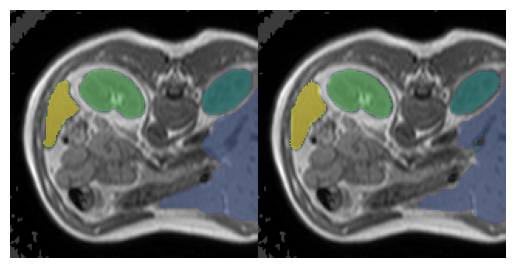

In [32]:
N = torch.argmax((val_source_label==3).sum([1,2]),0)
val_and_pred = torch.cat((val_source_label[N],output_val.argmax(1)[N]),1).data.cpu()
plt.imshow(val_source_img[N,0].cpu().repeat(1,2),'gray')
plt.imshow(val_and_pred,alpha=.5*(val_and_pred>0).float())
plt.axis('off')
plt.show()

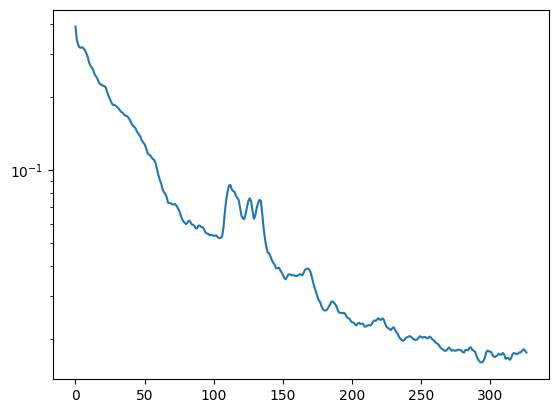

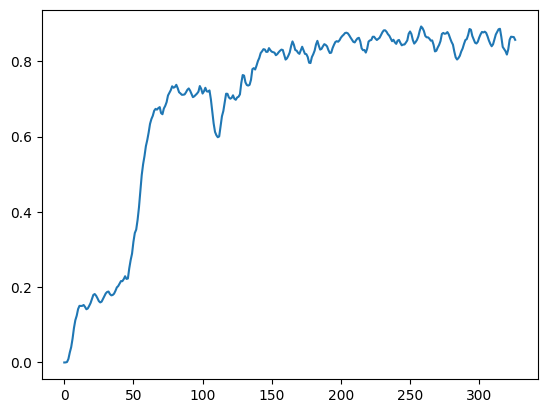

In [33]:
plt.semilogy(F.avg_pool1d(F.avg_pool1d(run_loss[:i,0].view(1,1,-1),15,stride=3),15,stride=3).squeeze())
plt.show()
plt.plot(F.avg_pool1d(F.avg_pool1d(run_loss[:i,1].view(1,1,-1),15,stride=3),15,stride=3).squeeze())
plt.show()

In [22]:
test_target_data = torch.load('HackathonDA_CHAOS_T2.pth')['test_data']

In [30]:
print(test_target_data[0].shape)

torch.Size([1, 30, 196, 275])


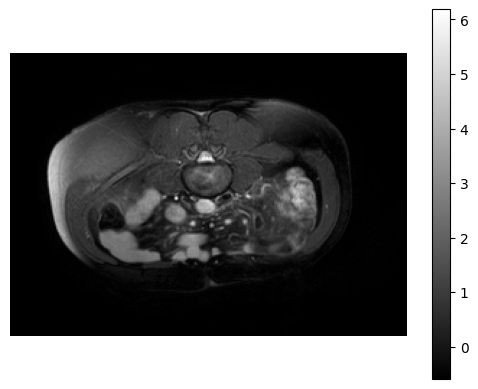

In [35]:

plt.imshow(test_target_data[0][0,0].cpu(),'gray')
plt.colorbar()
plt.axis('off')
plt.show()